In [1]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Requirements



1.   Connect colab to your google drive
2.   Navigate into the folder where the unet is stored



In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
import sys
sys.path.insert(0, '/gdrive/MyDrive/unet-nested-multiple-classification')

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import argparse
import logging
import os
import os.path as osp
from PIL import Image

# Change this path to wherever you installed the Pytorch-UNet module
#sys.path.append('C:/Users/Groh/Documents/GitHub/unet-nested-multiple-classification')
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from unet import NestedUNet
from unet import UNet
from utils.dataset import BasicDataset
from config import UNetConfig

from losses import LovaszLossSoftmax
from losses import LovaszLossHinge
from losses import dice_coeff

import cv2
! pip install albumentations==0.4.6
import albumentations as A
import albumentations.augmentations.functional as Fu
from albumentations.pytorch.transforms import ToTensorV2
import copy

from os.path import splitext
from os import listdir

from glob import glob

from torchvision.transforms import functional as func
from numpy import moveaxis
import matplotlib.pyplot as plt





     |████████████████████████████████| 122kB 3.8MB/s 
     |████████████████████████████████| 952kB 4.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65175 sha256=7b06b2ba8cb56aaabc8d7deb887adb41a565f1364e8e7576f4a80c096e5d0db1
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


#### Assing absolute paths of image and mask folders

In [6]:
# Change this path to the respective image and mask folders

#dir_img_train = '../gdrive/MyDrive/imgs_masks_256x144/images_training/'
#dir_mask_train = '../gdrive/MyDrive/imgs_masks_256x144/masks_grayscale/'

#dir_img_val = '../gdrive/MyDrive/imgs_masks_256x144/images_all/'
#dir_mask_val = '../gdrive/MyDrive/imgs_masks_256x144/masks_grayscale/'


dir_img = '../gdrive/MyDrive/unet-nested-multiple-classification/data/images/'
dir_mask = '../gdrive/MyDrive/unet-nested-multiple-classification/data/masks/'

dir_checkpoint = '../gdrive/MyDrive/unet-nested-multiple-classification/data/checkpoints/'

#print(dir_img)
#print(dir_mask)
#print(dir_checkpoint)



#dir_img = 'C:/Users/Groh/Documents/GitHub/unet-nested-multiple-classification/data/images/'
#print(dir_img)
#dir_mask = 'C:/Users/Groh/Documents/GitHub/unet-nested-multiple-classification/data/masks/'
#dir_checkpoint = 'C:/Users/Groh/Documents/GitHub/unet-nested-multiple-classification/data/checkpoints/'

#### Prepare masks for multi instance segmentation

In [7]:
convert_files = False

In [8]:
num_files = len([f for f in os.listdir(dir_img)if os.path.isfile(os.path.join(dir_img, f))])

if convert_files:
    for i in range(num_files):
        name = os.listdir(dir_img)[i]
        file = dir_mask+name

        # If a mask is missing, create a new, empty mask
        if not os.path.isfile(file):
            img = Image.open(dir_img+name)
            width, height = img.size

            img_new = Image.new('L', (width, height))
            img_new.save(file, "PNG")

        # Convert all images to 8-bit gray scales
        img_grayscale = Image.open(file).convert('L')
        img_grayscale.save(file)


        # Check, whether more than background is visible in the mask
        image_gray = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        unique = np.unique(image_gray.flatten())
        if len(unique) > 1:
            # For every pixel change gray-scale value according to categorical value
            img = Image.open(file)
            # Create pixel map
            pixels = img.load()
            for ii in range(img.size[0]): 
                for j in range(img.size[1]):
                    if pixels[ii,j] == 52: # Atraum. Pinzette
                        pixels[ii,j] = 1
                    elif pixels[ii,j] == 113: # Nadelhalter
                        pixels[ii,j] = 2
    #                     elif pixels[i,j] = 52:
    #                         pixels[i,j] = 1
    #                     elif pixels[i,j] = 52:
    #                         pixels[i,j] = 1
    #                     elif pixels[i,j] = 52:
    #                         pixels[i,j] = 1
    #                     elif pixels[i,j] = 52:
    #                         pixels[i,j] = 1
    #                     elif pixels[i,j] = 52:
    #                         pixels[i,j] = 1
            img.save(file)

## Data Augmentation

Returns a list of the filenames of those session you want <br>
Parameter: <br>


-directory: directory where images/masks are stored <br>
-sessions: session numbers you want to include in dataset <br>
  -> hand in as list <br>
  -> example: if you want to include session 06 and 07 to dataset, write following: getSelectedFilenames(directory, ['06', '07']) <br>







In [9]:
def getSelectedFilenames(directory, sessions):
  all_filenames = list(sorted(os.listdir(directory)));
  #print(all_filenames)
  selected_filenames = []
  
  for session in sessions:
    string = 'aicm' + session;
    for name in all_filenames:
      if string in name:
       selected_filenames.append(name);

  #print(selected_filenames)   
  return selected_filenames;

#getSelectedFilenames(dir_img, ['05_02', '06']);

Returns a list of the filenames of those session you want <br>
Parameter: <br>


-images_directory: directory where images are stored <br>
-masks_directory: directory where masks are stored <br>
-sessions: session numbers you want to include in dataset <br>
  -> hand in as list <br>
  -> example: if you want to include session 06 and 07 to dataset, write following: getSelectedFilenames(directory, ['06', '07']) <br>
-transform: albumentations compose object - optional, just add for training data, you don't need augmented pictures for validation






In [10]:
#erstellt Dataset mit Trainingsbildern und -masken
class CustomDataset(Dataset):
    def __init__(self, images_directory, masks_directory, sessions, transform=None):   
        self.images_filenames = getSelectedFilenames(images_directory, sessions);
        self.images_directory = images_directory;
        self.masks_directory = masks_directory;
        self.transform = transform;
        self.sessions = sessions  

        #print(self.images_filenames[0])             

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        #print(self.images_filenames)
        image_filename = self.images_filenames[idx]

        pathImage = os.path.join(self.images_directory, image_filename);
        pathMask = os.path.join(self.masks_directory, image_filename);
        
        pillow_image = Image.open(pathImage)
        image = np.array(pillow_image)
        pillow_mask = Image.open(pathMask)
        mask = np.array(pillow_mask)
        
        if self.transform is not None:
          transformed = self.transform(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]
          image = np.array(image)
          mask = np.array(mask)
         
          #to get channels_first format
          #image_np = moveaxis(image_np, 2,0)
                    
         
          #image_tensor = torch.from_numpy(image_np).type(torch.FloatTensor)
          #mask_tensor = torch.from_numpy(mask_np).type(torch.FloatTensor)

        image = func.to_tensor(np.array(image))
        mask = func.to_tensor(np.array(mask)) 


        return {
            'image': image,
            'mask':  mask
        } 

    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans         
        
#tatsächliche Augmentation
#möglicherweise noch andere Transformationen einfügen

train_transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.Rotate (limit=[-10, 10]),
    A.Blur (blur_limit=4, always_apply=False, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    #A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
    #A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
])


sessions = ['05_02', '05_03']
train_data = CustomDataset(dir_img, dir_mask, sessions, train_transform)  

val_data = CustomDataset(dir_img, dir_mask, sessions)
train_data.__len__()                           
train_data.__getitem__(5);

print(train_data.__getitem__(5)['mask'].shape)
print(train_data.__getitem__(5)['image'].shape)

print(val_data.__getitem__(5)['mask'].shape)
print(val_data.__getitem__(5)['image'].shape)



torch.Size([1, 432, 768])
torch.Size([3, 432, 768])
torch.Size([1, 432, 768])
torch.Size([3, 432, 768])


Set up training and validation datasets <br>


Parameter: <br>

-dir_img_train: directory where images for training are stored <br>
-dir_mask_train: directory where masks for training are stored <br>
-dir_img_val: directory where images for validation are stored <br>
-dir_mask_val: directory where masks for validation are stored <br>
-train_transform: albumentations compose object for training images/masks, which you want to augment
-sessions_train: session numbers of training_data you want to include in dataset <br>
  -> hand in as list <br>
  -> example: if you want to include session 06 and 07 to dataset, write following: getSelectedFilenames(directory, ['06', '07'])  <br>
  -sessions_val: session numbers of training_data you want to include in dataset <br>
  -> hand in as list <br>
  -> example: if you want to include session 06 and 07 to dataset, write following: getSelectedFilenames(directory, ['06', '07']) 






In [11]:
def setupDatasets(dir_img_train, dir_mask_train, dir_img_val, dir_mask_val ,train_transform, sessions_train, sessions_val):
  train_dataset = CustomDataset(dir_img_train, dir_mask_train, sessions_train, train_transform)
  val_dataset = CustomDataset(dir_img_val, dir_mask_val, sessions_val)
  return train_dataset, val_dataset

trainingData, validationData = setupDatasets(dir_img, dir_mask, dir_img, dir_mask, train_transform, ['05_02', '05_03', '06_02' ], ['06_03']) 

print((trainingData.__getitem__(5)['image'].shape))
print((trainingData.__getitem__(5)['mask'].shape))
print((validationData.__getitem__(5)['image'].shape))
print((validationData.__getitem__(5)['mask'].shape))

torch.Size([3, 432, 768])
torch.Size([1, 432, 768])
torch.Size([3, 432, 768])
torch.Size([1, 432, 768])


Visualization of different augmentations applied to the same image and the associated mask

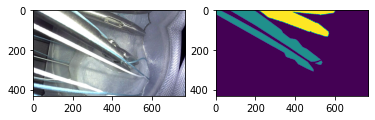

In [12]:
def visualize(dataset):
  index = np.random.choice(dataset.__len__(), 1)
  dictionary = dataset.__getitem__(index[0]);
  dictionary2 = dataset.__getitem__(index[0]);
  #print(type(dictionary))

  image, mask = dictionary["image"], dictionary["mask"]
  image = image.numpy().transpose((1,2,0))
  mask = mask.numpy().transpose((1,2,0))
 
  image2, mask2 = dictionary2["image"], dictionary2["mask"]
  image2 = image2.numpy().transpose((1,2,0))
  mask2 = mask2.numpy().transpose((1,2,0))
 
  plt.subplot(1, 2, 1) 
  plt.imshow(image)

  plt.subplot(1, 2, 2) 
  plt.imshow(np.squeeze(mask))  # zero'th channel is the background, 1st channel is the foreground or gauss points

  plt.subplot(2, 2, 1) 
  plt.imshow(image2)

  plt.subplot(2, 2, 2) 
  plt.imshow(np.squeeze(mask2))

visualize(train_data)

#### Train network

In [13]:
# Change UNet configuration if necessary
# Also important to change n_channels and n_classes
cfg = UNetConfig()

# Training function
def train_net(net, cfg, train_dataset, val_dataset):
    #val_percent = cfg.validation / 100
    #n_val = int(len(train_dataset) * val_percent)
    #n_train = len(train_dataset) - n_val
       
    train = train_dataset

    #steps per epoch? --> n_train
    n_train = 50
    n_val = 10

    val = val_dataset
   
    train_loader = DataLoader(train,
                              batch_size=cfg.batch_size,
                              shuffle=True,
                              num_workers=8,
                              pin_memory=True)
    val_loader = DataLoader(val,
                            batch_size=cfg.batch_size,
                            shuffle=False,
                            num_workers=8,
                            pin_memory=True)

    writer = SummaryWriter(comment=f'LR_{cfg.lr}_BS_{cfg.batch_size}_SCALE_{cfg.scale}')
    global_step = 0

    logging.info(f'''Starting training:
        Epochs:          {cfg.epochs}
        Batch size:      {cfg.batch_size}
        Learning rate:   {cfg.lr}
        Optimizer:       {cfg.optimizer}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {cfg.save_cp}
        Device:          {device.type}
        Images scaling:  {cfg.scale}
    ''')

    if cfg.optimizer == 'Adam':
        optimizer = optim.Adam(net.parameters(),
                               lr=cfg.lr)
    elif cfg.optimizer == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(),
                                  lr=cfg.lr,
                                  weight_decay=cfg.weight_decay)
    else:
        optimizer = optim.SGD(net.parameters(),
                              lr=cfg.lr,
                              momentum=cfg.momentum,
                              weight_decay=cfg.weight_decay,
                              nesterov=cfg.nesterov)

    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=cfg.lr_decay_milestones,
                                               gamma = cfg.lr_decay_gamma)
    if cfg.n_classes > 1:
        criterion = LovaszLossSoftmax()
    else:
        criterion = LovaszLossHinge()

    for epoch in range(cfg.epochs):
        net.train()

        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{cfg.epochs}', unit='img') as pbar:
            for batch in train_loader:
                batch_imgs = batch['image']
                batch_masks = batch['mask']
                assert batch_imgs.shape[1] == cfg.n_channels, \
                        f'Network has been defined with {cfg.n_channels} input channels, ' \
                        f'but loaded images have {batch_imgs.shape[1]} channels. Please check that ' \
                        'the images are loaded correctly.'

                batch_imgs = batch_imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if cfg.n_classes == 1 else torch.long
                batch_masks = batch_masks.to(device=device, dtype=mask_type)

                inference_masks = net(batch_imgs)

                #vergleich generierte masken mit ground truth masken
                if cfg.n_classes == 1:
                    inferences = inference_masks.squeeze(1)
                    masks = batch_masks.squeeze(1)
                else:
                    inferences = inference_masks
                    masks = batch_masks

                if cfg.deepsupervision:
                    loss = 0
                    for inference_mask in inferences:
                        loss += criterion(inference_mask, masks)
                    loss /= len(inferences)
                else:
                    loss = criterion(inferences, masks)

                epoch_loss += loss.item()
                writer.add_scalar('Loss/train', loss.item(), global_step)
                writer.add_scalar('model/lr', optimizer.param_groups[0]['lr'], global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                pbar.update(batch_imgs.shape[0])
                global_step += 1

                if global_step % (n_train // (1 * cfg.batch_size)) == 0:
                    val_score = eval_net(net, val_loader, device, n_val, cfg)
                    if cfg.n_classes > 1:
                        logging.info('Validation cross entropy: {}'.format(val_score))
                        writer.add_scalar('CrossEntropy/test', val_score, global_step)
                    else:
                        logging.info('Validation Dice Coeff: {}'.format(val_score))
                        writer.add_scalar('Dice/test', val_score, global_step)

                    writer.add_images('images', batch_imgs, global_step)
                    if cfg.deepsupervision:
                            inference_masks = inference_masks[-1]
                    if cfg.n_classes == 1:
                        # writer.add_images('masks/true', batch_masks, global_step)
                        inference_mask = torch.sigmoid(inference_masks) > cfg.out_threshold
                        writer.add_images('masks/inference',
                                          inference_mask,
                                          global_step)
                    else:
                        # writer.add_images('masks/true', batch_masks, global_step)
                        ids = inference_masks.shape[1]  # N x C x H x W
                        inference_masks = torch.chunk(inference_masks, ids, dim=1)
                        for idx in range(0, len(inference_masks)):
                            inference_mask = torch.sigmoid(inference_masks[idx]) > cfg.out_threshold
                            writer.add_images('masks/inference_'+str(idx),
                                              inference_mask,
                                              global_step)
                            
        #changed cfg.checkpoints_dir to dir_checkpoint
        if cfg.save_cp:
            try:
                os.mkdir(dir_checkpoint)
                logging.info('Created checkpoint directory')
            except OSError:
                pass

            ckpt_name = 'epoch_' + str(epoch + 1) + '.pth'
            torch.save(net.state_dict(),
                       osp.join(dir_checkpoint, ckpt_name))
            logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()
    

# Evaluation function
def eval_net(net, loader, device, n_val, cfg):
    """
    Evaluation without the densecrf with the dice coefficient

    """
    net.eval()
    tot = 0

    with tqdm(total=n_val, desc='Validation round', unit='img', leave=False) as pbar:
        for batch in loader:
            imgs = batch['image']
            true_masks = batch['mask']

            imgs = imgs.to(device=device, dtype=torch.float32)
            mask_type = torch.float32 if cfg.n_classes == 1 else torch.long
            true_masks = true_masks.to(device=device, dtype=mask_type)

            # compute loss
            if cfg.deepsupervision:
                masks_preds = net(imgs)
                loss = 0
                for masks_pred in masks_preds:
                    tot_cross_entropy = 0
                    for true_mask, pred in zip(true_masks, masks_pred):
                        pred = (pred > cfg.out_threshold).float()
                        if cfg.n_classes > 1:
                            sub_cross_entropy = F.cross_entropy(pred.unsqueeze(dim=0), true_mask.unsqueeze(dim=0).squeeze(1)).item()
                        else:
                            sub_cross_entropy = dice_coeff(pred, true_mask.squeeze(dim=1)).item()
                        tot_cross_entropy += sub_cross_entropy
                    tot_cross_entropy = tot_cross_entropy / len(masks_preds)
                    tot += tot_cross_entropy
            else:
                masks_pred = net(imgs)
                for true_mask, pred in zip(true_masks, masks_pred):
                    pred = (pred > cfg.out_threshold).float()
                    if cfg.n_classes > 1:
                        tot += F.cross_entropy(pred.unsqueeze(dim=0), true_mask.unsqueeze(dim=0).squeeze(1)).item()
                    else:
                        tot += dice_coeff(pred, true_mask.squeeze(dim=1)).item()

            pbar.update(imgs.shape[0])

    return tot / n_val


#### Configure training parameters and device

In [14]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Automatically uses a GPU, if it is available to torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
logging.info(f'Using device {device}')

net = eval(cfg.model)(cfg)
logging.info(f'Network:\n'
             f'\t{cfg.model} model\n'
             f'\t{cfg.n_channels} input channels\n'
             f'\t{cfg.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if cfg.bilinear else "Dilated conv"} upscaling')

if cfg.load:
    net.load_state_dict(
        torch.load(cfg.load, map_location=device)
    )
    logging.info(f'Model loaded from {cfg.load}')

net.to(device=device);
# faster convolutions, but more memory
# cudnn.benchmark = True

INFO: Using device cpu
INFO: Network:
	NestedUNet model
	3 input channels
	6 output channels (classes)
	Bilinear upscaling


#### Call the training function

In [ ]:
try:
    train_net(net=net, cfg=cfg, train_dataset=trainingData, val_dataset=validationData)
except KeyboardInterrupt:
    
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    logging.info('Saved interrupt')
    try:
        sys.exit(0)
    except SystemExit:
        os._exit(0)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
INFO: Starting training:
        Epochs:          3
        Batch size:      2
        Learning rate:   0.0001
        Optimizer:       SGD
        Training size:   50
        Validation size: 10
        Checkpoints:     True
        Device:          cpu
        Images scaling:  0.3333333333333333
    
Epoch 1/3:   0%|          | 0/50 [00:00<?, ?img/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current

## Testdata

In [ ]:
def inference_one(net, image, device):
    net.eval()

    img = torch.from_numpy(BasicDataset.preprocess(image, cfg.scale))

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)
        if cfg.deepsupervision:
            output = output[-1]

        if cfg.n_classes > 1:
            probs = F.softmax(output, dim=1)
        else:
            probs = torch.sigmoid(output)

        probs = probs.squeeze(0)

        tf = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize((image.size[1], image.size[0])),
                transforms.ToTensor()
            ]
        )
        
        if cfg.n_classes == 1:
            probs = tf(probs.cpu())
            mask = probs.squeeze().cpu().numpy()
            return mask > cfg.out_threshold
        else:
            masks = []
            for prob in probs:
                prob = tf(prob.cpu())
                mask = prob.squeeze().cpu().numpy()
                mask = mask > cfg.out_threshold
                masks.append(mask)
            return masks
  
#image_dir = 
#inference_one(net, image, device)